In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
from ete3 import PhyloTree
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, get_farthest_leaf
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

In [2]:
# Load rates and cats
dtypes_rate = {"Site": np.int16, "Cat": np.int8}

rate_nd1 = pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb = pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb.head()

,Site,Rate,Cat,C_Rate
0,1,0.00187,0,0.00000
1,2,0.00003,0,0.00000
2,3,0.01569,1,0.01569
3,4,0.19571,2,0.12291
4,5,0.37341,3,0.37341


In [3]:
# Load OBS
dtypes = dict(
    Mut=str,
    Label=np.int8, 
    PosInGene=np.int16,
    ProbaMut=np.float32, 
    ProbaFull=np.float32,
    RefNode=str,
    AltNode=str,
)
usecols = list(dtypes.keys())
usecols_simple = [x for x in usecols if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_nd1/"
mut_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_nd1["MutBase"] = mut_nd1["Mut"].str.slice(2, 5).astype("category")


PATH_TO_DATA = "../data/exposure/mammals_cytb/"
mut_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_cytb["MutBase"] = mut_cytb["Mut"].str.slice(2, 5).astype("category")

mut_nd1 = mut_nd1[mut_nd1.RefNode != "ROOT"]
mut_cytb = mut_cytb[mut_cytb.RefNode != "ROOT"]

mut_nd1 = mut_nd1.merge(rate_nd1[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")
mut_cytb = mut_cytb.merge(rate_cytb[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")

In [5]:
# Load EXP
dtypes_exp = dict(
    Mut=str,
    Label=str, 
    Pos=np.int16,
    Proba=np.float32, 
    Node=str,
)
usecols_exp = list(dtypes_exp.keys())
usecols_exp_simple = [x for x in usecols_exp if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_cytb/"
exp_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))


PATH_TO_DATA = "../data/exposure/mammals_nd1/"
exp_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))

exp_nd1 = exp_nd1[(exp_nd1.Mut.isin(possible_sbs192)) & (exp_nd1.Node != "ROOT")]
exp_cytb = exp_cytb[(exp_cytb.Mut.isin(possible_sbs192)) & (exp_cytb.Node != "ROOT")]

exp_nd1["Cat"] = exp_nd1.Pos.map(rate_nd1.set_index("Site").Cat.to_dict()).astype(np.int8)
exp_cytb["Cat"] = exp_cytb.Pos.map(rate_cytb.set_index("Site").Cat.to_dict()).astype(np.int8)

### Add phylocoef of alt node

In [8]:
#calculate node-specific phylocoefs

tree_cytb = PhyloTree("../data/exposure/mammals_cytb/iqtree_anc_tree.nwk", format=1)
tree_nd1  = PhyloTree("../data/exposure/mammals_nd1/iqtree_anc_tree.nwk", format=1)

max_dist_cytb = get_farthest_leaf(tree_cytb, 0.95)
dist2leaf_cytb = {}
phylocoefs_cytb = {}
for node in tree_cytb.iter_descendants():
    d = node.get_closest_leaf()[1]
    dist2leaf_cytb[node.name]  = d
    phylocoefs_cytb[node.name] = 1 - min(0.9999, d / max_dist_cytb)

max_dist_nd1 = get_farthest_leaf(tree_nd1, 0.95)
dist2leaf_nd1 = {}
phylocoefs_nd1 = {}
for node in tree_nd1.iter_descendants():
    d = node.get_closest_leaf()[1]
    dist2leaf_nd1[node.name]  = d
    phylocoefs_nd1[node.name] = 1 - min(0.9999, d / max_dist_nd1)

In [9]:
# update 'ProbaFull' for OBS ND1
mut_nd1['RefPhylocoef'] = mut_nd1['ProbaFull'] / mut_nd1['ProbaMut']
mut_nd1['RefPhylocoefTrue'] = mut_nd1.RefNode.map(phylocoefs_nd1).astype(np.float32)

assert np.allclose(
    mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoef'].values, 
    mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoefTrue'])

mut_nd1['AltPhylocoefTrue'] = mut_nd1.AltNode.map(phylocoefs_nd1).astype(np.float32)
mut_nd1['PhylocoefTotal'] = 1
mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'PhylocoefTotal'] = mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoefTrue'] \
                                                                        * mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'AltPhylocoefTrue']
mut_cytb['ProbaNotFull'] = mut_cytb['ProbaFull']
mut_cytb['ProbaFull'] = mut_cytb['ProbaMut'] * mut_cytb['PhylocoefTotal']

# update 'ProbaFull' for OBS CYTB
mut_cytb['RefPhylocoef'] = mut_cytb['ProbaFull'] / mut_cytb['ProbaMut']
mut_cytb['RefPhylocoefTrue'] = mut_cytb.RefNode.map(phylocoefs_cytb).astype(np.float32)

assert np.allclose(
    mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoef'].values, 
    mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoefTrue'])

mut_cytb['AltPhylocoefTrue'] = mut_cytb.AltNode.map(phylocoefs_cytb).astype(np.float32)
mut_cytb['PhylocoefTotal'] = 1
mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'PhylocoefTotal'] = mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoefTrue'] \
                                                                          * mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'AltPhylocoefTrue']
mut_nd1['ProbaNotFull'] = mut_nd1['ProbaFull']
mut_nd1['ProbaFull'] = mut_nd1['ProbaMut'] * mut_nd1['PhylocoefTotal']

## Calculate freqs

In [15]:
low_cat = 4
pcutoff = 0.3

In [16]:
# # # ORIGINAL (exp without probability filtration)
# # freqs_nd1_high_rate = exp_nd1[exp_nd1.Cat > low_cat].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
# # freqs_nd1_low_rate = exp_nd1[exp_nd1.Cat <= low_cat].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

# # freqs_cytb_high_rate = exp_cytb[exp_cytb.Cat > low_cat].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
# # freqs_cytb_low_rate = exp_cytb[exp_cytb.Cat <= low_cat].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

# assert freqs_nd1_high_rate.shape[1] == 192
# assert freqs_nd1_low_rate.shape[1] == 192
# assert freqs_cytb_high_rate.shape[1] == 192
# assert freqs_cytb_low_rate.shape[1] == 192

# freqs_nd1_high_rate = freqs_nd1_high_rate.reset_index()
# freqs_nd1_low_rate = freqs_nd1_low_rate.reset_index()
# freqs_cytb_high_rate = freqs_cytb_high_rate.reset_index()
# freqs_cytb_low_rate = freqs_cytb_low_rate.reset_index()

## Categorizing mutations

In [17]:
def calc_tree_mutspec(obs: pd.DataFrame, exp: pd.DataFrame, pmin=0.0, pmax=1.0, scale=True):
    obs[obs.ProbaFull.between(pmin, pmax, "right")]
        
    obs = obs[obs.ProbaFull.between(pmin, pmax, "right")]
    exp = exp[exp.Proba.between(pmin, pmax, "right")]
    if obs.ProbaFull.sum() < 100:
        return None
    obs_freqs = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
    assert len(obs_freqs) > 0
    exp_freqs = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
    assert len(exp_freqs) > 0

    for sbs192 in possible_sbs192:
        if sbs192 not in obs_freqs.columns:
            obs_freqs[sbs192] = 0.0
        if sbs192 not in exp_freqs.columns:
            exp_freqs[sbs192] = 0.0

    edges_df = obs_freqs.index.to_frame(False)
    exp_freqs = edges_df.merge(exp_freqs.reset_index(), left_on="RefNode", right_on="Node")\
        .set_index(["RefNode", "AltNode"])
    
    indexes = obs_freqs.index.intersection(exp_freqs.index)
    obs_freqs = obs_freqs.loc[indexes, possible_sbs192]
    exp_freqs = exp_freqs.loc[indexes, possible_sbs192]
        
    assert (obs_freqs.columns == exp_freqs.columns).all()
    assert (obs_freqs.index == exp_freqs.index).all()

    spectra = (obs_freqs / exp_freqs).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    return spectra


### SYN (phylo-like adjusting)

In [18]:
# space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]
space = [0.00, 0.30, 1.00]

exp_cytb_syn = exp_cytb[exp_cytb.Label == 'syn']
exp_nd1_syn = exp_nd1[exp_nd1.Label == 'syn']

mut_cytb_syn = mut_cytb[mut_cytb.Label >= 1]
mut_nd1_syn = mut_nd1[mut_nd1.Label >= 1]

In [41]:
lbl = "syn"

ms_cat_cytb = []
ms_cat_nd1 = []

_high = ''.join([str(x) for x in range(low_cat+1, 7)])
_low  = ''.join([str(x) for x in range(1, low_cat+1)])

for apr in mut_cytb_syn.Aproach.unique():
    if "simple" in apr:
        continue
    mapr_cytb = mut_cytb_syn[(mut_cytb_syn.Aproach == apr)]
    mapr_nd1  = mut_nd1_syn[(mut_nd1_syn.Aproach == apr)]
    eapr_cytb = exp_cytb_syn[exp_cytb_syn.Aproach == apr]
    eapr_nd1  = exp_nd1_syn[exp_nd1_syn.Aproach == apr]

    for p1, p2 in zip(space[:-1], space[1:]):
        # CYTB
        # print(f"{apr}, {p1}-{p2}, cytb low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec(
            mapr_cytb[(mapr_cytb.Cat <= low_cat)],
            eapr_cytb[eapr_cytb.Cat <= low_cat], p1, p2)
        if ms_low_rate is not None:
            ms_cat_cytb.append(ms_low_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate=_low))

        # print(f"{apr}, {p1}-{p2}, cytb high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec(
            mapr_cytb[(mapr_cytb.Cat > low_cat)], 
            eapr_cytb[eapr_cytb.Cat > low_cat], p1, p2)
        if ms_high_rate is not None:
            ms_cat_cytb.append(ms_high_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate=_high))

        # ND1
        # print(f"{apr}, {p1}-{p2}, nd1 low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec(
            mapr_nd1[(mapr_nd1.Cat <= low_cat)], 
            eapr_nd1[eapr_nd1.Cat <= low_cat], p1, p2)
        if ms_low_rate is not None:
            ms_cat_nd1.append(ms_low_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate=_low))

        # print(f"{apr}, {p1}-{p2}, nd1 high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec(
            mapr_nd1[(mapr_nd1.Cat > low_cat)], 
            eapr_nd1[eapr_nd1.Cat > low_cat], p1, p2)
        if ms_high_rate is not None:
            ms_cat_nd1.append(ms_high_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate=_high))


ms_cat_cytb_df_wide = pd.concat(ms_cat_cytb)
ms_cat_nd1_df_wide  = pd.concat(ms_cat_nd1)

ms_cat_cytb_df = ms_cat_cytb_df_wide.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")
ms_cat_nd1_df  = ms_cat_nd1_df_wide.reset_index().melt( ["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")

In [22]:
ms_cat_cytb_df.Aproach.unique()

array(['gtr', 'RY10.12', 'pastml'], dtype=object)

In [46]:
# only 123456 categories
exp_cytb.Cat.value_counts()

5    17057306
6    13596790
1     6374215
4     5017314
2     2791038
3     2434132
Name: Cat, dtype: int64

In [50]:
mean_mammals_spectra = pd.concat([ms_cat_cytb_df.assign(Gene='cytb'), 
           ms_cat_nd1_df.assign(Gene='nd1')], ignore_index=True)\
                .groupby(['Gene', 'Aproach', 'Cat', 'Rate', 'Mut']).MutSpec.mean()\
                    .unstack().rename_axis(index={'Cat': 'ProbaCat', 'Rate':'RateCat'})

mean_mammals_spectra.to_csv('../data/share/mean_mammals_spectra.csv', float_format='%g')
mean_mammals_spectra

Mut                             A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T   A[A>G]A  \
Gene Aproach ProbaCat  RateCat                                                 
cytb RY10.12 0.00_0.30 1234         0.0      0.0      0.0      0.0  0.016722   
                       56           0.0      0.0      0.0      0.0  0.000558   
             0.30_1.00 1234         0.0      0.0      0.0      0.0  0.027683   
                       56           0.0      0.0      0.0      0.0  0.005909   
     gtr     0.00_0.30 1234         0.0      0.0      0.0      0.0  0.016970   
                       56           0.0      0.0      0.0      0.0  0.000524   
             0.30_1.00 1234         0.0      0.0      0.0      0.0  0.028582   
                       56           0.0      0.0      0.0      0.0  0.006352   
     pastml  0.00_0.30 1234         0.0      0.0      0.0      0.0  0.009203   
                       56           0.0      0.0      0.0      0.0  0.000456   
             0.30_1.00 1234         0.0      0.0      0.0      0.0  0.023698   
                       56           0.0      0.0      0.0      0.0  0.006619   
nd1  RY10.12 0.00_0.30 1234         0.0      0.0      0.0      0.0  0.004346   
                       56           0.0      0.0      0.0      0.0  0.002815   
             0.30_1.00 1234         0.0      0.0      0.0      0.0  0.016872   
                       56           0.0      0.0      0.0      0.0  0.005512   
     gtr     0.00_0.30 1234         0.0      0.0      0.0      0.0  0.004966   
                       56           0.0      0.0      0.0      0.0  0.002244   
             0.30_1.00 1234         0.0      0.0      0.0      0.0  0.017282   
                       56           0.0      0.0      0.0      0.0  0.005896   
     pastml  0.00_0.30 1234         0.0      0.0      0.0      0.0  0.003102   
                       56           0.0      0.0      0.0      0.0  0.002983   
             0.30_1.00 1234         0.0      0.0      0.0      0.0  0.016864   
                       56           0.0      0.0      0.0      0.0  0.006444   

Mut                              A[A>G]C   A[A>G]G   A[A>G]T  A[A>T]A  \
Gene Aproach ProbaCat  RateCat                                          
cytb RY10.12 0.00_0.30 1234     0.002925  0.005443  0.005535      0.0   
                       56       0.004057  0.000383  0.003880      0.0   
             0.30_1.00 1234     0.018710  0.015671  0.021061      0.0   
                       56       0.006177  0.003753  0.008105      0.0   
     gtr     0.00_0.30 1234     0.002718  0.004105  0.005565      0.0   
                       56       0.003746  0.000419  0.003248      0.0   
             0.30_1.00 1234     0.018589  0.016333  0.020926      0.0   
                       56       0.006737  0.003554  0.008498      0.0   
     pastml  0.00_0.30 1234     0.003406  0.003533  0.008306      0.0   
                       56       0.003802  0.000419  0.003037      0.0   
             0.30_1.00 1234     0.015402  0.014111  0.018793      0.0   
                       56       0.006425  0.003656  0.009995      0.0   
nd1  RY10.12 0.00_0.30 1234     0.006862  0.007897  0.002983      0.0   
                       56       0.003351  0.001966  0.006130      0.0   
             0.30_1.00 1234     0.045846  0.039231  0.006611      0.0   
                       56       0.006393  0.006103  0.009248      0.0   
     gtr     0.00_0.30 1234     0.006803  0.008120  0.003418      0.0   
                       56       0.002652  0.001556  0.004822      0.0   
             0.30_1.00 1234     0.045740  0.039416  0.006258      0.0   
                       56       0.006596  0.005692  0.009955      0.0   
     pastml  0.00_0.30 1234     0.006792  0.008769  0.001268      0.0   
                       56       0.003940  0.001080  0.008942      0.0   
             0.30_1.00 1234     0.041599  0.035768  0.005725      0.0   
                       56       0.006061  0.005527  0.008522      0.0   

Mut                 

In [49]:
base_outpath = '../figures/approaches/mammals_{gene}_{apr}_{lbl}_ratecat{ratecat}.{ext}'

for apr in ms_cat_cytb_df.Aproach.unique():
    if "simple" in apr:
        continue
    print(apr)
    for rt in ms_cat_cytb_df.Rate.unique():
        if rt == "1234":
            continue
        
        gene = 'cytb'
        spectra_cytb = ms_cat_cytb_df[(ms_cat_cytb_df.Aproach == apr) & (ms_cat_cytb_df.Rate == rt)]
        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=spectra_cytb, 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='svg'), bbox_inches="tight")
        plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='pdf'), bbox_inches="tight")
        plt.close()

        gene = 'nd1'
        spectra_nd1 = ms_cat_nd1_df[(ms_cat_nd1_df.Aproach == apr) & (ms_cat_nd1_df.Rate == rt)]
        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=spectra_nd1, 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='svg'), bbox_inches="tight")
        plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='pdf'), bbox_inches="tight")
        plt.close()


gtr
RY10.12
pastml


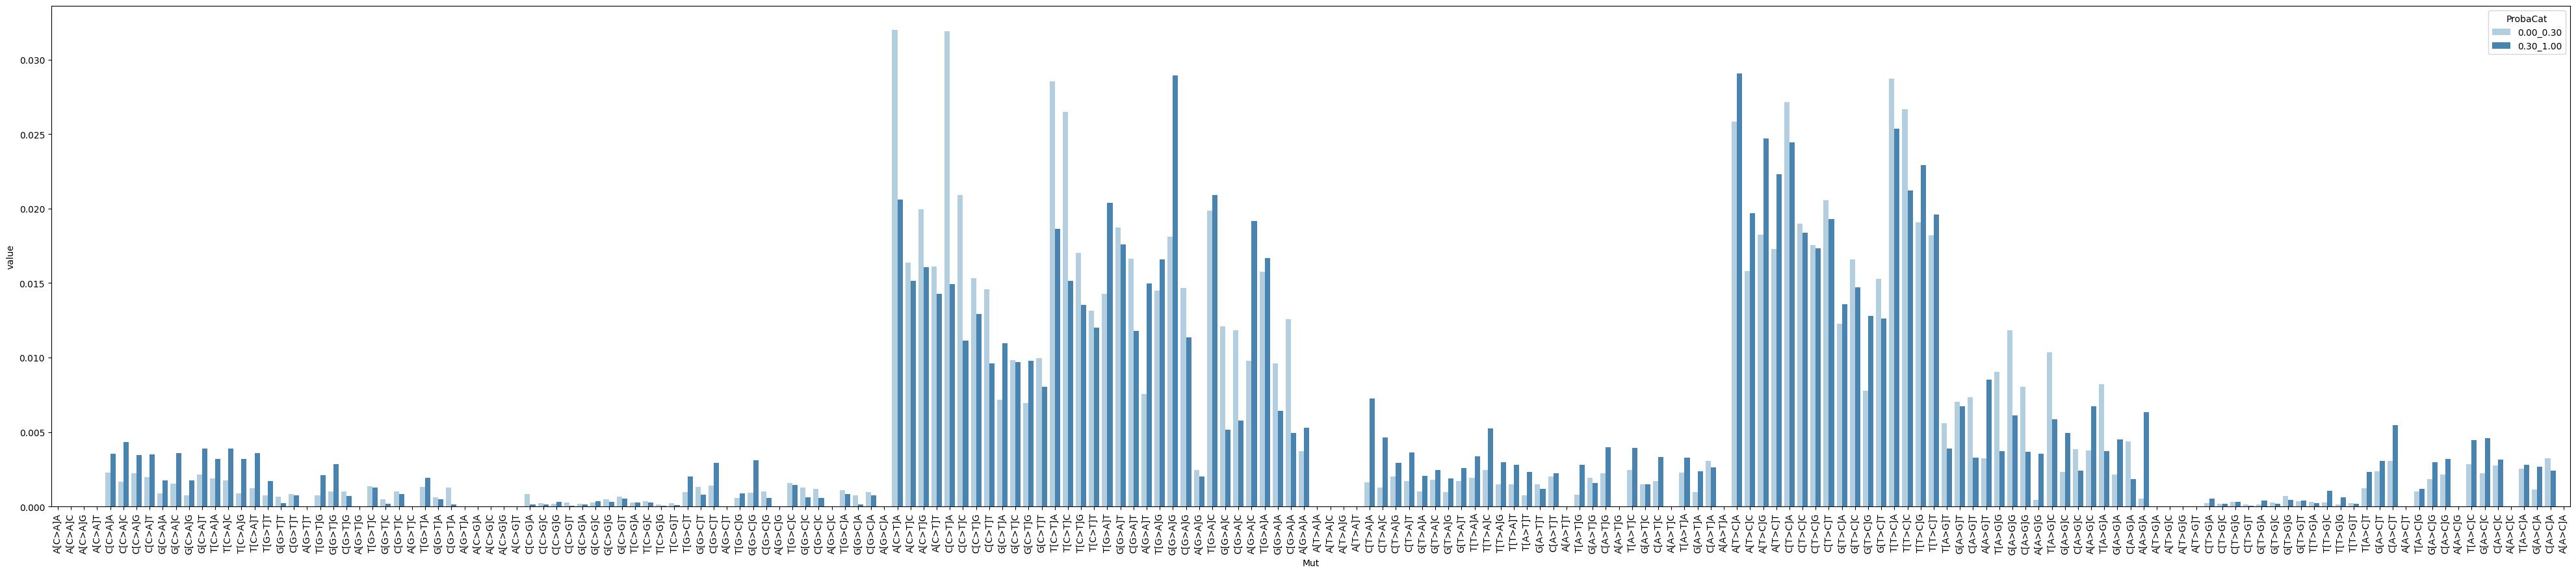

In [73]:
# check that mean values 
df = mean_mammals_spectra.reset_index().melt(mean_mammals_spectra.index.names, possible_sbs192)

plt.figure(figsize=(50, 10))
sns.barplot(
    x="Mut", y="value", hue="ProbaCat", 
    data=df[(df.Gene=='cytb')&(df.Aproach=='gtr')&(df.RateCat=='56')], 
    errwidth=1, order=ordered_sbs192_kp, palette="Blues",
)
plt.xticks(rotation=90);
# plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='svg'), bbox_inches="tight")
# plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='pdf'), bbox_inches="tight")
# plt.close()